## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, norm

In [2]:
#!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

## 데이터 로드
* parquet 형식 로드를 위한 라이브러리가 설치되어 있어야 합니다.

In [3]:
df = pd.read_parquet("https://github.com/corazzon/KaggleStruggle/raw/master/online-retail/data/online_retail.gzip")
df.shape

(541909, 8)

In [4]:
# 주문 가격
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    541909 non-null  category
 1   StockCode    541909 non-null  category
 2   Description  540455 non-null  category
 3   Quantity     541909 non-null  int32   
 4   InvoiceDate  541909 non-null  category
 5   UnitPrice    541909 non-null  float64 
 6   CustomerID   406829 non-null  float32 
 7   Country      541909 non-null  category
 8   TotalPrice   541909 non-null  float64 
dtypes: category(5), float32(1), float64(2), int32(1)
memory usage: 19.3 MB


## 미션 1) 모집단과 표본 추출을 하고 TotalPrice에 대해 비교해 주세요.
데이터셋에서 무작위로 1000개의 표본을 추출하고, 추출된 표본과 전체 데이터셋의 'TotalPrice'에 대해 평균과 표준편차를 비교하세요. 이를 통해 모집단과 표본의 차이를 설명하고, 중심극한정리가 어떻게 적용되는지 설명하세요.

* pandas 의 sample 을 활용할 수 있으며, pandas 의 기술 통계 기능을 활용해 볼 수 있습니다.
* 참고 : 슬라이드에서 중심극한정리를 찾아보세요.

In [6]:
# 1000개 표본 추출
sample_df = df.sample(n = 1000, random_state = 1)

In [7]:
# 모집단의 평균 및 표준편차
population_mean = df['TotalPrice'].mean()
population_std = df['TotalPrice'].std()

# 표본의 평균 및 표준편차
sample_mean = df['TotalPrice'].mean()
sample_std = df['TotalPrice'].std()

print(f'모집단의 평균: {population_mean}, 모집단의 표준편차: {population_std}')
print(f'표본의 평균: {sample_mean}, 표본의 표준편차: {sample_std}')

모집단의 평균: 17.98779487699964, 모집단의 표준편차: 378.81082350615196
표본의 평균: 17.98779487699964, 표본의 표준편차: 378.81082350615196


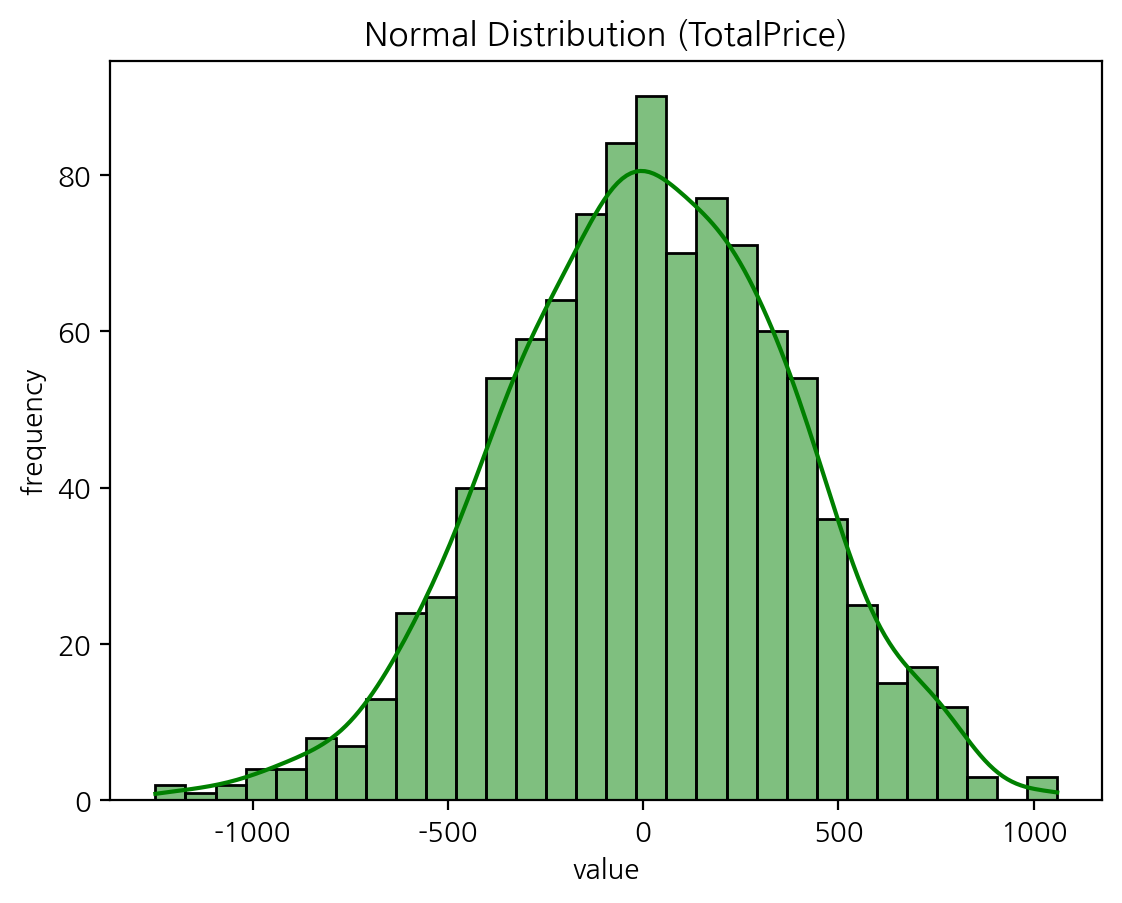

In [8]:
# 정규분포 시뮬레이션
mu, sigma = population_mean, population_std
s = np.random.normal(mu, sigma, 1000)

sns.histplot(s, bins=30, kde=True, color='green')
plt.title('Normal Distribution (TotalPrice)')
plt.xlabel('value')
plt.ylabel('frequency')
plt.show()

## 미션2) 'Country' 변수를 바탕으로 가장 빈도가 높은 두 개의 국가를 선택하고, 각 국가의 'TotalPrice' 평균에 차이가 있는지 검증하세요. 독립표본 t-검정을 사용하여 가설을 설정하고 검정하며, 1종 오류와 2종 오류에 대해 설명하세요.


* 미션 진행 방법
    <br>1) 데이터 로드 후 'TotalPrice'와 'Country' 컬럼을 찾아주세요.
    <br>2) 데이터셋에서 주문이 가장 많은 상위 두 국가를 찾아주세요.
    <br>3) 통계적 검증 수행하기
    <br>4) 각 국가의 'TotalPrice' 평균을 계산하세요.
    <br>5) 독립표본 t-검정을 사용하여 두 국가 간 'TotalPrice' 평균의 차이가 통계적으로 유의미한지 검증하세요. 이 때, scipy.stats 라이브러리의 ttest_ind 함수를 사용할 수 있습니다. equal_var=False 파라미터를 설정하여 두 집단의 분산이 다르다고 가정하세요.
    <br>6) t-통계량과 p-값을 해석하여 결과를 설명하세요. 1종 오류와 2종 오류의 개념을 설명하고, 해당 데이터셋에 적용하여 설명해 주세요.

In [9]:
# 0) 데이터 로드
df = pd.read_parquet("https://github.com/corazzon/KaggleStruggle/raw/master/online-retail/data/online_retail.gzip")
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   InvoiceNo    541909 non-null  category
 1   StockCode    541909 non-null  category
 2   Description  540455 non-null  category
 3   Quantity     541909 non-null  int32   
 4   InvoiceDate  541909 non-null  category
 5   UnitPrice    541909 non-null  float64 
 6   CustomerID   406829 non-null  float32 
 7   Country      541909 non-null  category
 8   TotalPrice   541909 non-null  float64 
dtypes: category(5), float32(1), float64(2), int32(1)
memory usage: 19.3 MB


In [10]:
# 1) 데이터 로드 후 'TotalPrice'와 'Country' 컬럼을 찾아주세요.
df_country = df[['TotalPrice', 'Country']]
df_country

,TotalPrice,Country
0,15.30,United Kingdom
1,20.34,United Kingdom
2,22.00,United Kingdom
3,20.34,United Kingdom
4,20.34,United Kingdom
...,...,...
541904,10.20,France
541905,12.60,France
541906,16.60,France
541907,16.60,France


In [11]:
# 2) 데이터셋에서 주문이 가장 많은 상위 두 국가를 찾아주세요.

df_country['Country'].value_counts().head(2)

Country
United Kingdom    495478
Germany             9495
Name: count, dtype: int64

In [12]:
# 3) 통계적 검증 수행하기
# 4) 각 국가의 'TotalPrice' 평균을 계산하세요.

# 각 국가의 데이터 추출
data_country_1 = df[df['Country'] == 'United Kingdom']['TotalPrice']
data_country_2 = df[df['Country'] == 'Germany']['TotalPrice']

# 각 국가의 'TotalPrice' 평균 계산
mean_country_1 = data_country_1.mean()
mean_country_2 = data_country_2.mean()

print(mean_country_1)
print(mean_country_2)

16.525065419655366
23.348942601369142


In [13]:
# 3) 통계적 검증 수행하기
# 5) 독립표본 t-검정을 사용하여 두 국가 간 'TotalPrice' 평균의 차이가 통계적으로 유의미한지 검증하세요. 이 때, scipy.stats 라이브러리의 ttest_ind 함수를 사용할 수 있습니다.
#    equal_var=False 파라미터를 설정하여 두 집단의 분산이 다르다고 가정하세요.

# 독립표본 t-검정 수행
t_stat, p_value = stats.ttest_ind(data_country_1, data_country_2, equal_var=False)

# t-통계량과 p-값 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -10.046360185819829
p-value: 9.823416115791871e-24


p-값이 매우 작으므로 (보통 0.05보다 작을 때 유의미하다고 간주), 귀무 가설(두 국가의 평균에 차이가 없다)을 기각할 수 있음.

- 1종 오류
    - 귀무 가설이 사실일 때, 귀무 가설을 잘못 기각하는 오류 
    - 실제로 두 국가의 평균에 차이가 없음에도 불구하고, 차이가 있다고 잘못 결론 내리는 경우
- 2종 오류
    - 대립 가설이 사실일 때, 귀무 가설을 잘못 채택하는 오류
    - 실제로 두 국가의 평균에 차이가 있음에도 불구하고, 차이가 없다고 잘못 결론 내리는 경우

이 경우, p-값이 매우 작기 때문에 1종 오류를 범할 확률은 낮음.

## 미션 3) 주중, 주말에 따른 기술통계와 분위수 분석

'UnitPrice'의 분포를 분석하기 위해 상자수염그림과 히스토그램을 그리세요. 데이터의 분위수, 중심경향치(평균, 중간값), 변산성(표준편차, 분산)을 계산하고, 이들이 데이터 분포에 대해 설명해 주세요. 다음의 주어진 코드를 활용해 주세요.


```python
# 'InvoiceDate' 컬럼을 이용하여 주중과 주말을 구분
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek


df.loc[df['DayOfWeek'] <= 4, "WeekEnd"] = "주중"
df.loc[df['DayOfWeek'] > 4, "WeekEnd"] = "주말"

# 주중(월요일=0, 화요일=1, ..., 금요일=4)과 주말(토요일=5, 일요일=6)으로 데이터를 분리
weekday_data = df[df['DayOfWeek'] <= 4]  # 주중
weekend_data = df[df['DayOfWeek'] > 4]   # 주말
```

* 참고 : [pandas.DataFrame.describe — pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
* 참고 : 슬라이드의 "기술 통계" 부분을 찾아보세요.

In [14]:
# 'InvoiceDate' 컬럼을 이용하여 주중과 주말을 구분
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek


df.loc[df['DayOfWeek'] <= 4, "WeekEnd"] = "weekday"
df.loc[df['DayOfWeek'] > 4, "WeekEnd"] = "weekend"

# 주중(월요일=0, 화요일=1, ..., 금요일=4)과 주말(토요일=5, 일요일=6)으로 데이터를 분리
weekday_data = df[df['DayOfWeek'] <= 4]  # 주중
weekend_data = df[df['DayOfWeek'] > 4]   # 주말

In [15]:
# # 상자수염그림과 히스토그램 그리기
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.boxplot(x='WeekEnd', y='UnitPrice', data=df)
# plt.title('Box Plot of UnitPrice')

# plt.subplot(1, 2, 2)
# sns.histplot(data=df, x='UnitPrice', hue='WeekEnd', kde=True)
# plt.title('Histogram of UnitPrice')
# plt.show()

In [16]:
# 기술통계 계산
description = df.groupby('WeekEnd')['UnitPrice'].describe()
print(description)

            count      mean         std       min   25%   50%   75%       max
WeekEnd                                                                      
weekday  477534.0  4.843425  103.032058 -11062.06  1.25  2.10  4.13  38970.00
weekend   64375.0  2.887824    7.959497      0.00  1.25  1.85  3.75   1236.75


- 주중의 'UnitPrice'는 평균과 중간값이 비교적 높으며, 최대값도 주말보다 높음
    = 주중에 더 높은 가격대의 상품이 판매될 수 있음
- 표준편차가 비슷하므로, 두 그룹 모두 유사한 가격 변동성을 보임

## 미션4)  'TotalPrice'의 중간값이 특정 값과 다른지 검증하기 위해 비모수 검정 (예: 맨-휘트니 U-검정)을 사용하세요. 검증 결과에 대해 비즈니스 관점에서 분석해 주세요.

* 비모수 검정은 데이터가 정규 분포를 따르지 않거나, 정규 분포에 대한 가정을 할 수 없을 때 사용됩니다. 특히, 작은 표본 크기, 이상치의 존재, 순위나 순서와 같은 비정량적 데이터에 적합합니다. 또한, 두 그룹 간의 중앙값이나 분포의 형태가 다를 때 비모수 검정을 사용할 수 있습니다.

* 맨-휘트니 U-검정은 두 독립적인 표본 간에 중앙값의 차이를 비교하는 데 사용됩니다. 이 검정은 두 그룹의 데이터가 서로 독립적이며, 최소한 서열 척도로 측정되어야 합니다. 데이터의 분포 형태에 대한 가정이 필요 없으며, 크기가 다른 두 표본에 대해서도 사용할 수 있습니다. 이 검정은 데이터의 중앙값이 특정 값과 다른지 여부를 검증하는 데 유용합니다.

다음의 주어진 코드를 활용해 주세요.

```python
from scipy.stats import mannwhitneyu
# 'TotalPrice' 컬럼을 생성합니다. 이는 'Quantity'와 'UnitPrice'의 곱으로 정의됩니다.
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
```

* 참고 : https://www.ibm.com/docs/ko/spss-statistics/beta?topic=tests-mann-whitney-u-test

In [17]:
from scipy.stats import mannwhitneyu

# 'TotalPrice' 컬럼을 생성합니다. 이는 'Quantity'와 'UnitPrice'의 곱으로 정의됩니다.
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [24]:
# 두 그룹 선택 (주중과 주말)
group1 = df[df['WeekEnd'] == '주중']['TotalPrice']
group2 = df[df['WeekEnd'] == '주말']['TotalPrice']

group1

Series([], Name: TotalPrice, dtype: float64)

In [21]:
# 맨-휘트니 U-검정 수행
u_statistic, p_value = mannwhitneyu(group1, group2)
print("U-Statistic:", u_statistic)
print("P-Value:", p_value)

ValueError: `x` and `y` must be of nonzero size.

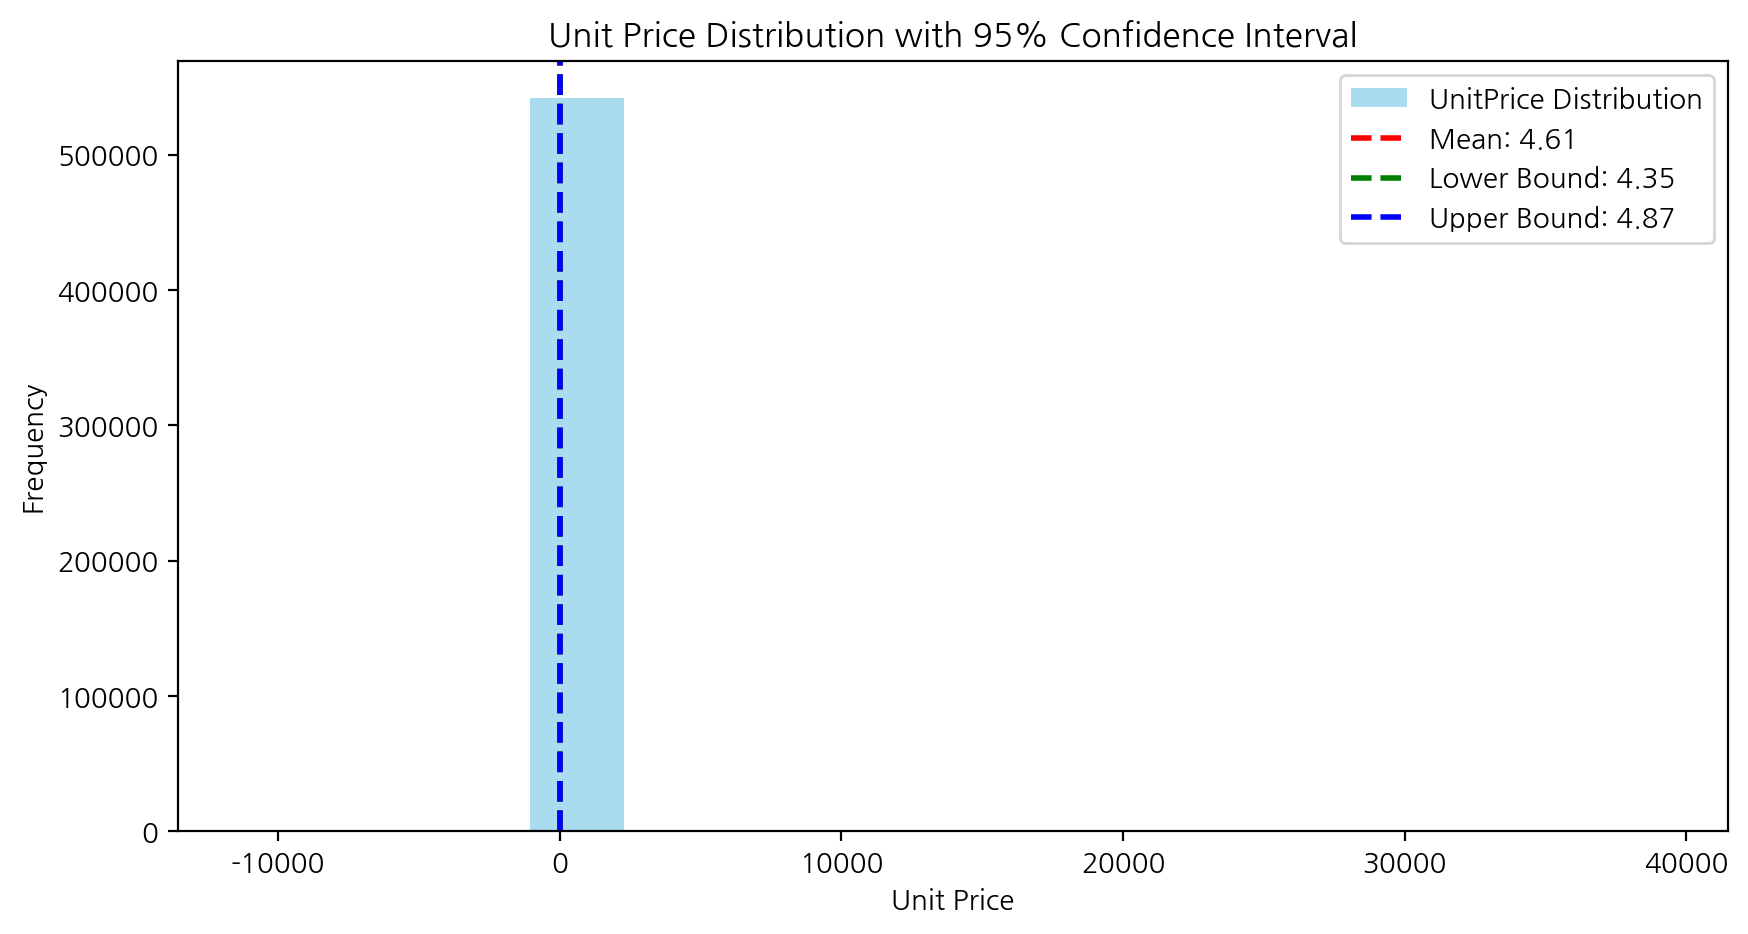

In [25]:
# 'UnitPrice'에 대한 샘플 크기, 평균, 표준편차 계산
sample_size = len(df['UnitPrice'])
sample_mean = df['UnitPrice'].mean()
sample_std = df['UnitPrice'].std()

# 신뢰구간 계산 (t-분포 사용)
confidence_level = 0.95
alpha = 1 - confidence_level
t_critical = stats.t.ppf(1 - alpha/2, df=sample_size-1)  # t-분포의 임계값
margin_of_error = t_critical * (sample_std / np.sqrt(sample_size))
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

# 점추정 및 신뢰구간 시각화
plt.figure(figsize=(10, 5))
plt.hist(df['UnitPrice'], bins=15, color='skyblue', alpha=0.7, label='UnitPrice Distribution')
plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sample_mean:.2f}')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label=f'Lower Bound: {confidence_interval[0]:.2f}')
plt.axvline(confidence_interval[1], color='blue', linestyle='dashed', linewidth=2, label=f'Upper Bound: {confidence_interval[1]:.2f}')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.title('Unit Price Distribution with 95% Confidence Interval')
plt.legend()
plt.show()